#Imports and Mounting

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

MessageError: ignored

In [ ]:
%cd /gdrive/MyDrive/rul/anshul/
%ls

#Parameters and Functions

In [ ]:
#PARAMS
BATCH_SIZE = 32
TIME_STEPS = 8
EPOCHS     = 100
SPLIT      = 0.5

In [ ]:
#FUNCTIONS

def create_sequences(xdat,ydat):
  x=[]
  for i in range(TIME_STEPS,len(xdat)+1):
    x.append(xdat[i-TIME_STEPS:i,:])
  return np.stack(x),ydat[TIME_STEPS-1:,:]

def shuffle_data(xdat,ydat):
  idx = np.random.permutation(len(xdat))
  xdat = xdat[idx]
  ydat = ydat[idx]
  return xdat,ydat

def split_data(xdat,ydat,split=SPLIT):
  limit = int(len(xdat)*(1-split))
  return xdat[:limit,:,:],ydat[:limit,:],xdat[limit:,:,:],ydat[limit:,:]

def mish(x):
  return tf.multiply(tf.activations.tanh(tf.activations.softplus(x)),x)



#Data Frame

In [ ]:
x_df     =  pd.read_csv('discharge.csv').drop(['datetime','time','capacity','ambient_temperature'],axis=1).groupby('cycle').mean()
'''
x_dfmed  =  pd.read_csv('discharge.csv').drop(['datetime','time','capacity','ambient_temperature'],axis=1).groupby('cycle').median()
x_dfmin  =  pd.read_csv('discharge.csv').drop(['datetime','time','capacity','ambient_temperature'],axis=1).groupby('cycle').min()
x_dfmax  =  pd.read_csv('discharge.csv').drop(['datetime','time','capacity','ambient_temperature'],axis=1).groupby('cycle').max()
x_df     =  pd.concat([x_df, x_dfmed, x_dfmin, x_dfmax], axis=1)
'''
x_df

In [ ]:
y_df = pd.read_csv('discharge_2.csv').drop(['datetime','cycle','ambient_temperature'],axis=1)
y_df

#Data Preprocess

In [ ]:
x_dat = x_df.to_numpy()
y_dat = y_df.to_numpy()

x_dat = ( x_dat - np.amin(x_dat,axis=0) ) / ( np.amax(x_dat,axis=0) - np.amin(x_dat,axis=0) + 10e-10)
y_dat = ( y_dat - np.amin(y_dat,axis=0) ) / ( np.amax(y_dat,axis=0) - np.amin(y_dat,axis=0) + 10e-10) 

x_dat, y_dat = create_sequences(x_dat,y_dat)
#x_dat, y_dat = shuffle_data(x_dat,y_dat)

x_train, y_train, x_test, y_test = split_data(x_dat,y_dat)

print([each.shape for each in [x_train, y_train, x_test, y_test]])

print(x_dat.shape,y_dat.shape)

#Toy Model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8, 5)]            0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 8, 5)             0         
 se)                                                             
                                                                 
 batch_normalization (BatchN  (None, 8, 5)             20        
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 8, 32)             832       
                                                                 
 activation (Activation)     (None, 8, 32)             0         
                                                                 
 dropout (Dropout)           (None, 8, 32)             0   

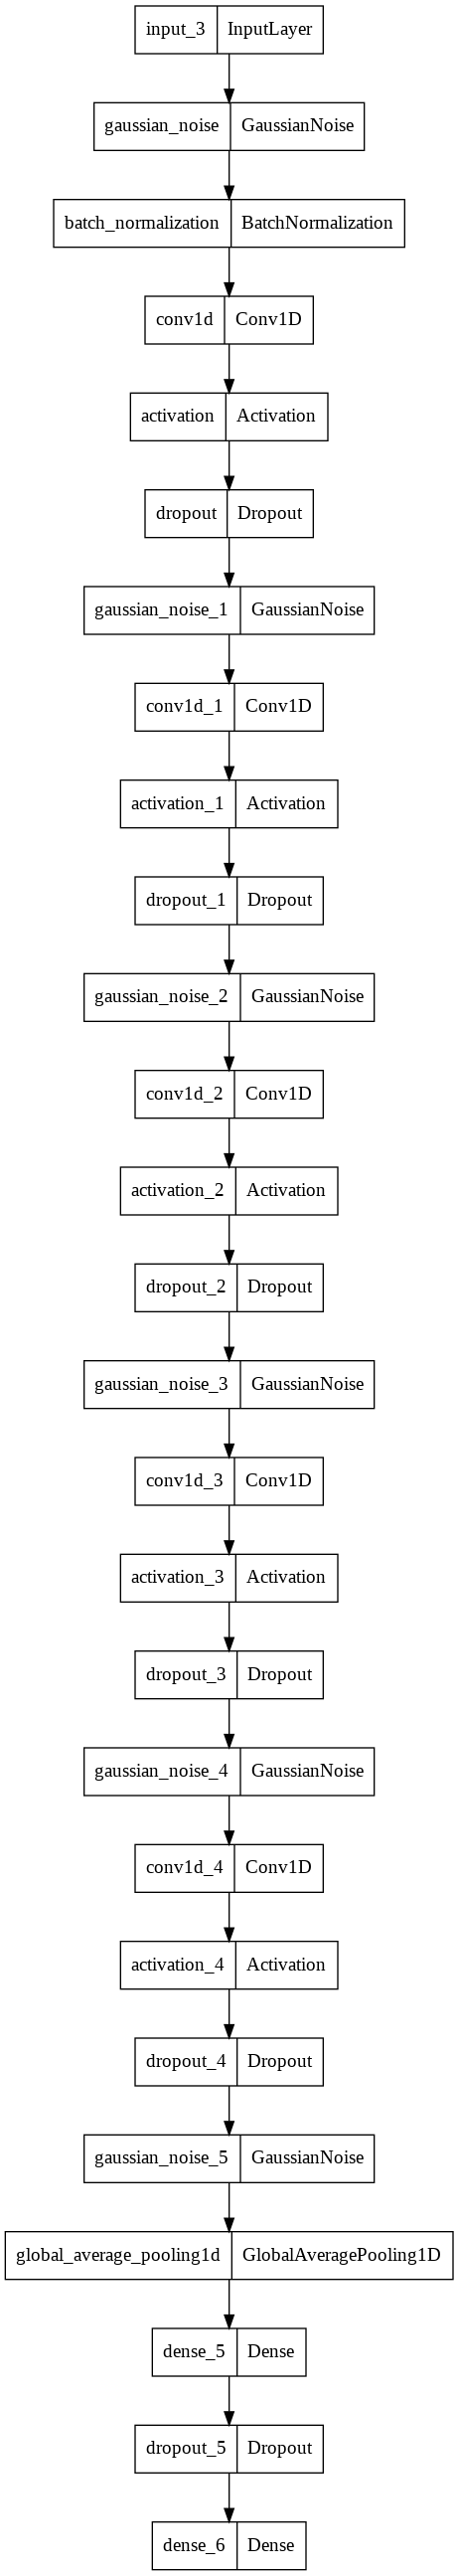

In [ ]:
#MODEL
act = 'swish'
kr  = keras.regularizers.l2(10e-5)

inp  = keras.layers.Input(x_train[0].shape)
pre  = keras.layers.GaussianNoise(0.3)(inp)
conv = keras.layers.BatchNormalization()(pre)
conv = keras.layers.Conv1D(32,5,kernel_regularizer=kr,padding='same')(conv)
#conv = keras.layers.BatchNormalization()(conv)
conv = keras.layers.Activation(act)(conv)
conv = keras.layers.Dropout(0.2)(conv)
conv  = keras.layers.GaussianNoise(0.3)(conv)


conv = keras.layers.Conv1D(64,3,kernel_regularizer=kr,padding='same')(conv)
#conv = keras.layers.BatchNormalization()(conv)
conv = keras.layers.Activation(act)(conv)
conv = keras.layers.Dropout(0.3)(conv)
conv  = keras.layers.GaussianNoise(0.3)(conv)

conv = keras.layers.Conv1D(64,3,kernel_regularizer=kr,padding='same')(conv)
#conv = keras.layers.BatchNormalization()(conv)
conv = keras.layers.Activation(act)(conv)
conv = keras.layers.Dropout(0.3)(conv)
conv  = keras.layers.GaussianNoise(0.3)(conv)


conv = keras.layers.Conv1D(128,3,kernel_regularizer=kr,padding='same')(conv)
#conv = keras.layers.BatchNormalization()(conv)
conv = keras.layers.Activation(act)(conv)
conv = keras.layers.Dropout(0.2)(conv)
conv  = keras.layers.GaussianNoise(0.2)(conv)

conv = keras.layers.Conv1D(128,3,kernel_regularizer=kr,padding='same')(conv)
#conv = keras.layers.BatchNormalization()(conv)
conv = keras.layers.Activation(act)(conv)
conv = keras.layers.Dropout(0.3)(conv)
conv  = keras.layers.GaussianNoise(0.2)(conv)

gap = keras.layers.GlobalAveragePooling1D()(conv)

dense = keras.layers.Dense(32,activation=act,kernel_regularizer=kr)(gap)
dense = keras.layers.Dropout(0.3)(dense)

out = keras.layers.Dense(1)(dense)


model = keras.models.Model(inputs=inp,outputs=out)
model.summary()
keras.utils.plot_model(model)

#Train

In [ ]:
#COMPILE

loss = [
        #'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.Adam( learning_rate = 0.001, decay = 10e-5 )
metrics = [
           'mae',
           'mape',
]

model.compile(loss = loss,optimizer=optimizer,metrics=metrics)

In [ ]:
#RUN

hist = model.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*20,
                  validation_data = ( x_test , y_test ),
                  batch_size = None,
                 )

Epoch 1/2000
3/3 [==============================] - 2s 172ms/step - loss: 0.3401 - mae: 0.7544 - mape: 98.1057 - val_loss: 0.0601 - val_mae: 0.1561 - val_mape: 556967.5000
Epoch 2/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.2392 - mae: 0.6009 - mape: 76.7195 - val_loss: 0.0533 - val_mae: 0.1267 - val_mape: 1211286.6250
Epoch 3/2000
3/3 [==============================] - 0s 36ms/step - loss: 0.1153 - mae: 0.3337 - mape: 42.4933 - val_loss: 0.0484 - val_mae: 0.1075 - val_mape: 2108974.5000
Epoch 4/2000
3/3 [==============================] - 0s 30ms/step - loss: 0.1012 - mae: 0.2697 - mape: 37.8509 - val_loss: 0.0474 - val_mae: 0.1020 - val_mape: 2077131.6250
Epoch 5/2000
3/3 [==============================] - 0s 33ms/step - loss: 0.0875 - mae: 0.2506 - mape: 35.1971 - val_loss: 0.0473 - val_mae: 0.1010 - val_mape: 1879455.3750
Epoch 6/2000
3/3 [==============================] - 0s 35ms/step - loss: 0.0653 - mae: 0.1907 - mape: 26.0188 - val_loss: 0.0478 - val_mae: 

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])


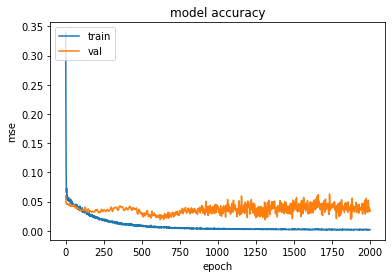

In [ ]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
x_eval = x_df.to_numpy()
y_eval = y_df.to_numpy()

x_eval = ( x_eval - np.amin(x_eval,axis=0) ) / ( np.amax(x_eval,axis=0) - np.amin(x_eval,axis=0) + 10e-10)
y_eval = ( y_eval - np.amin(y_eval,axis=0) ) / ( np.amax(y_eval,axis=0) - np.amin(y_eval,axis=0) + 10e-10)

x_eval, y_eval = create_sequences(x_eval,y_eval)


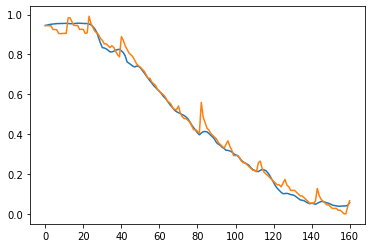

In [ ]:
plt.plot(model.predict(x_eval))
plt.plot(y_eval)
plt.show()

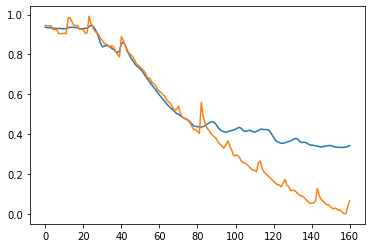

In [ ]:
plt.plot(model.predict(x_eval))
plt.plot(y_eval)
plt.show()

#ResNet-50

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 8, 5)]       0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 8, 16)        96          ['input_4[0][0]']                
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 8, 16)        64          ['conv1[0][0]']                  
                                                                                                  
 activation_5 (Activation)      (None, 8, 16)        0           ['bn_conv1[0][0]']               
                                                                                           

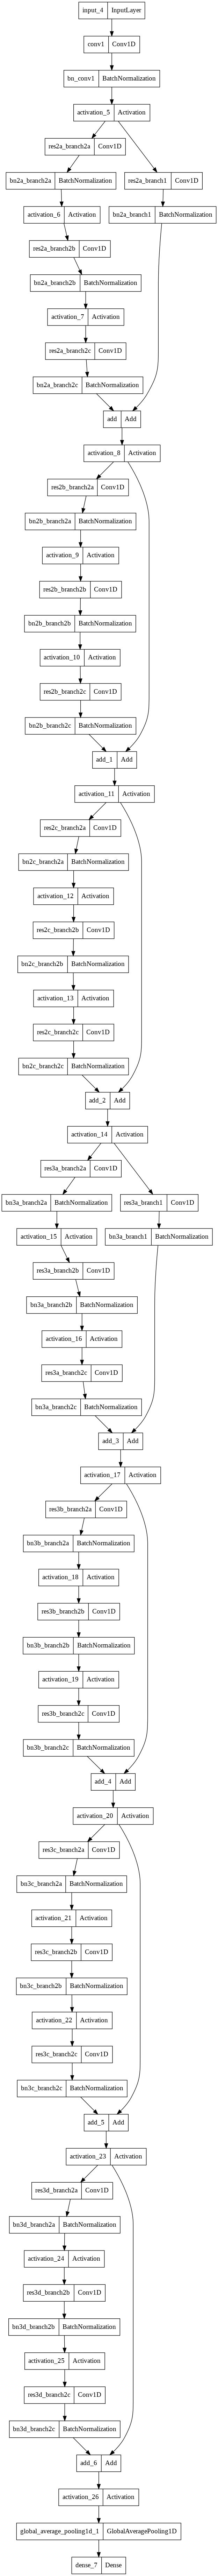

In [ ]:
kr = keras.regularizers.l2(0.001)
act = 'swish'

def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = keras.layers.Conv1D(filters=F1, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2a', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation(act)(X)

    X = keras.layers.Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation(act)(X)

    X = keras.layers.Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2c')(X)

    X = keras.layers.Add()([X, X_shortcut])# SKIP Connection
    X = keras.layers.Activation(act)(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv1D(filters=F1, kernel_size=1, strides=s, padding='valid', name=conv_name_base + '2a', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation(act)(X)

    X = keras.layers.Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation(act)(X)

    X = keras.layers.Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2c')(X)

    X_shortcut = keras.layers.Conv1D(filters=F3, kernel_size=1, strides=s, padding='valid', name=conv_name_base + '1', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '1')(X_shortcut)

    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation(act)(X)

    return X


def ResNet50(input_shape=x_train[0].shape):

    X_input = keras.layers.Input(input_shape)

    X = keras.layers.Conv1D(16, 1, strides=1, name='conv1', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X_input)
    X = keras.layers.BatchNormalization(axis=2, name='bn_conv1')(X)
    X = keras.layers.Activation(act)(X)

    X = convolutional_block(X, f=3, filters=[32, 32, 64], stage=2, block='a', s=1)
    X = identity_block(X, 3, [32, 32, 64], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 64], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[64, 64, 128], stage=3, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='c')
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='d')


    X = keras.layers.GlobalAveragePooling1D()(X)
    out = keras.layers.Dense(1)(X)
    
    model = keras.models.Model(inputs=X_input, outputs=out, name='ResNet50')

    return model

model = ResNet50()
model.summary()
keras.utils.plot_model(model)

In [ ]:
#COMPILE

loss = [
        #'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.Adam( learning_rate = 0.001, decay = 10e-5 )
metrics = [
           'mae',
           'mape',
]

model.compile(loss = loss,optimizer=optimizer,metrics=metrics)

In [ ]:
#RUN

hist = model.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*10,
                  validation_data = ( x_test , y_test ),
                  batch_size = None,
                 )

Epoch 1/1000
3/3 [==============================] - 11s 1s/step - loss: 1.7972 - mae: 0.8104 - mape: 112.0582 - val_loss: 1.3882 - val_mae: 0.1560 - val_mape: 550514.1250
Epoch 2/1000
3/3 [==============================] - 0s 91ms/step - loss: 1.5527 - mae: 0.3957 - mape: 65.5360 - val_loss: 1.3822 - val_mae: 0.1356 - val_mape: 990371.8750
Epoch 3/1000
3/3 [==============================] - 0s 90ms/step - loss: 1.4561 - mae: 0.3066 - mape: 46.8511 - val_loss: 1.3783 - val_mae: 0.1270 - val_mape: 1262246.2500
Epoch 4/1000
3/3 [==============================] - 0s 91ms/step - loss: 1.5850 - mae: 0.4516 - mape: 69.9245 - val_loss: 1.3760 - val_mae: 0.1248 - val_mape: 1345671.7500
Epoch 5/1000
3/3 [==============================] - 0s 65ms/step - loss: 1.4743 - mae: 0.2606 - mape: 37.4415 - val_loss: 1.3737 - val_mae: 0.1228 - val_mape: 1423653.5000
Epoch 6/1000
3/3 [==============================] - 0s 48ms/step - loss: 1.4933 - mae: 0.2783 - mape: 37.8412 - val_loss: 1.3714 - val_mae: 0.

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])


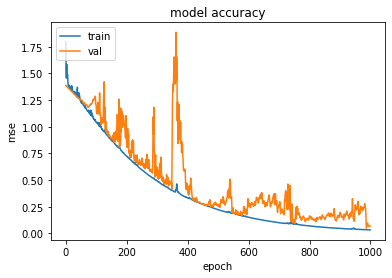

In [ ]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
x_eval = x_df.to_numpy()
y_eval = y_df.to_numpy()

x_eval = ( x_eval - np.amin(x_eval,axis=0) ) / ( np.amax(x_eval,axis=0) - np.amin(x_eval,axis=0) + 10e-10)
y_eval = ( y_eval - np.amin(y_eval,axis=0) ) / ( np.amax(y_eval,axis=0) - np.amin(y_eval,axis=0) + 10e-10)

x_eval, y_eval = create_sequences(x_eval,y_eval)


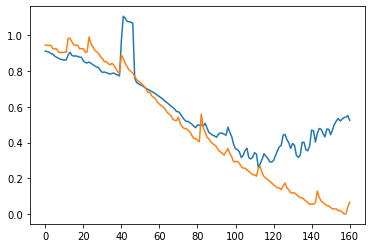

In [ ]:
plt.plot(model.predict(x_eval))
plt.plot(y_eval)
plt.show()

#The Neuron

In [ ]:
inp  = keras.layers.Input(x_train[0].shape)
flat = keras.layers.Flatten()(inp)
out  = keras.layers.Dense(1)(flat)

TheNeuron = keras.models.Model(inputs=inp,outputs=out)
TheNeuron.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 8, 5)]            0         
                                                                 
 flatten_4 (Flatten)         (None, 40)                0         
                                                                 
 dense_56 (Dense)            (None, 1)                 41        
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#COMPILE

loss = [
        #'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.Adam( learning_rate = 0.001, decay = 10e-5 )
metrics = [
           'mae',
           'mape',
]

TheNeuron.compile(loss = loss,optimizer=optimizer,metrics=metrics)

In [ ]:
#RUN

hist = TheNeuron.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*20,
                  validation_data = ( x_test , y_test ),
                  batch_size = None,
                 )

Epoch 1/2000
3/3 [==============================] - 47s 23s/step - loss: 5.8872e-04 - mae: 0.0275 - mape: 110953.7969 - val_loss: 0.0013 - val_mae: 0.0374 - val_mape: 11.3566
Epoch 2/2000
3/3 [==============================] - 0s 26ms/step - loss: 5.1281e-04 - mae: 0.0241 - mape: 314785.5000 - val_loss: 8.9016e-04 - val_mae: 0.0264 - val_mape: 9.6800
Epoch 3/2000
3/3 [==============================] - 0s 25ms/step - loss: 3.8872e-04 - mae: 0.0204 - mape: 275357.1875 - val_loss: 8.6992e-04 - val_mae: 0.0252 - val_mape: 9.5032
Epoch 4/2000
3/3 [==============================] - 0s 26ms/step - loss: 4.0224e-04 - mae: 0.0205 - mape: 298311.8750 - val_loss: 9.0247e-04 - val_mae: 0.0257 - val_mape: 10.4297
Epoch 5/2000
3/3 [==============================] - 0s 16ms/step - loss: 3.9027e-04 - mae: 0.0189 - mape: 467969.0000 - val_loss: 9.6879e-04 - val_mae: 0.0278 - val_mape: 10.8285
Epoch 6/2000
3/3 [==============================] - 0s 26ms/step - loss: 3.6997e-04 - mae: 0.0182 - mape: 43181

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])


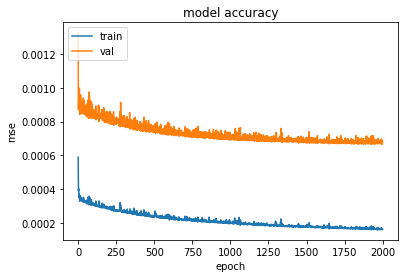

In [ ]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
x_eval = x_df.to_numpy()
y_eval = y_df.to_numpy()

x_eval = ( x_eval - np.amin(x_eval,axis=0) ) / ( np.amax(x_eval,axis=0) - np.amin(x_eval,axis=0) + 10e-10)
y_eval = ( y_eval - np.amin(y_eval,axis=0) ) / ( np.amax(y_eval,axis=0) - np.amin(y_eval,axis=0) + 10e-10)

x_eval, y_eval = create_sequences(x_eval,y_eval)


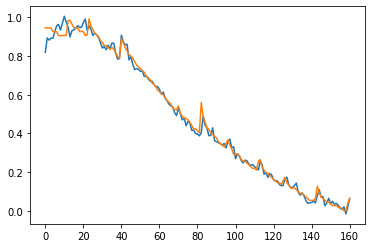

In [ ]:
plt.plot(TheNeuron.predict(x_eval))
plt.plot(y_eval)
plt.show()

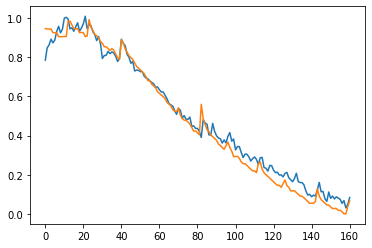

In [ ]:
plt.plot(TheNeuron.predict(x_eval))
plt.plot(y_eval)
plt.show()

#ANN

In [ ]:
kr = keras.regularizers.l2(0.00001)

inp  = keras.layers.Input(x_train[0].shape)
flat = keras.layers.Flatten()(inp)
dense  = keras.layers.Dense(16,activation='selu',kernel_regularizer=kr)(flat)
out  = keras.layers.Dense(1)(dense)

TheNeuron = keras.models.Model(inputs=inp,outputs=out)
TheNeuron.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 5)]            0         
                                                                 
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 16)                656       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#COMPILE

loss = [
        #'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.Adam( learning_rate = 0.001)

metrics = [
           'mae',
           'mape',
]

TheNeuron.compile(loss = loss,optimizer=optimizer,metrics=metrics)

In [ ]:
#RUN
callbacks=[
           keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.7,patience=5, min_lr=0.00001),
           keras.callbacks.EarlyStopping(monitor='loss', patience=50)
]
hist = TheNeuron.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*20,
                  validation_data = ( x_test , y_test ),
                  batch_size = None,
                  callbacks=callbacks
                 )

Epoch 1/2000
3/3 [==============================] - 1s 156ms/step - loss: 0.0394 - mae: 0.2236 - mape: 29.2423 - val_loss: 0.0699 - val_mae: 0.3341 - val_mape: 6501095.0000 - lr: 0.0010
Epoch 2/2000
3/3 [==============================] - 0s 31ms/step - loss: 0.0283 - mae: 0.1700 - mape: 20.6805 - val_loss: 0.0462 - val_mae: 0.2588 - val_mape: 5604097.0000 - lr: 0.0010
Epoch 3/2000
3/3 [==============================] - 0s 29ms/step - loss: 0.0237 - mae: 0.1600 - mape: 20.2213 - val_loss: 0.0421 - val_mae: 0.2449 - val_mape: 5403105.0000 - lr: 0.0010
Epoch 4/2000
3/3 [==============================] - 0s 53ms/step - loss: 0.0207 - mae: 0.1401 - mape: 17.6185 - val_loss: 0.0601 - val_mae: 0.3080 - val_mape: 6096207.0000 - lr: 0.0010
Epoch 5/2000
3/3 [==============================] - 0s 29ms/step - loss: 0.0190 - mae: 0.1358 - mape: 17.1692 - val_loss: 0.0623 - val_mae: 0.3178 - val_mape: 6109318.5000 - lr: 0.0010
Epoch 6/2000
3/3 [==============================] - 0s 33ms/step - loss: 0

In [ ]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
x_eval = x_df.to_numpy()
y_eval = y_df.to_numpy()

x_eval = ( x_eval - np.amin(x_eval,axis=0) ) / ( np.amax(x_eval,axis=0) - np.amin(x_eval,axis=0) + 10e-10)
y_eval = ( y_eval - np.amin(y_eval,axis=0) ) / ( np.amax(y_eval,axis=0) - np.amin(y_eval,axis=0) + 10e-10)

x_eval, y_eval = create_sequences(x_eval,y_eval)


In [ ]:
plt.plot(TheNeuron.predict(x_eval))
plt.plot(y_eval)
plt.show()
#NotShuffled

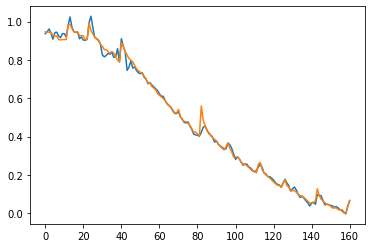

In [ ]:
plt.plot(TheNeuron.predict(x_eval))
plt.plot(y_eval)
plt.show()
#Shuffled

#ANN 2

In [ ]:
act  =  'tanh'
kr = tf.keras.regularizers.L1L2(l1=0.001, l2=0.002)

inp    = keras.layers.Input(x_train[0].shape)
flat   = keras.layers.Flatten()(inp)
#flat  = keras.layers.LayerNormalization()(flat)
flat  = keras.layers.Dropout(0.1)(flat)
dense  = keras.layers.Dense(16,activation=act,kernel_regularizer=kr)(flat)
#dense  = keras.layers.LayerNormalization()(dense)
dense  = keras.layers.Dense(8,activation=act,kernel_regularizer=kr)(dense)
out    = keras.layers.Dense(1)(dense)

TheNeuron = keras.models.Model(inputs=inp,outputs=out)
TheNeuron.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 8, 5)]            0         
                                                                 
 flatten_7 (Flatten)         (None, 40)                0         
                                                                 
 dropout_7 (Dropout)         (None, 40)                0         
                                                                 
 dense_21 (Dense)            (None, 16)                656       
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 801
Trainable params: 801
Non-trainable param

In [ ]:
#COMPILE

loss = [
        #'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.SGD( learning_rate = 0.005 )
metrics = [
           'mae',
           'mape',
]
TheNeuron.compile(loss = loss,optimizer=optimizer,metrics=metrics)

In [ ]:

#RUN

callbacks=[
           keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.7,patience=25,cooldown=50, min_lr=0.00007),
           keras.callbacks.EarlyStopping(monitor='loss', patience=1000)
]

hist = TheNeuron.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*50,
                  validation_data = ( x_test , y_test ),
                  batch_size = None,
                  callbacks=callbacks
                 )

Streaming output truncated to the last 5000 lines.
3/3 [==============================] - 0s 29ms/step - loss: 0.1972 - mae: 0.1098 - mape: 14.5925 - val_loss: 0.1876 - val_mae: 0.0484 - val_mape: 204001.0625 - lr: 7.0000e-05
Epoch 1624/5000
3/3 [==============================] - 0s 29ms/step - loss: 0.1930 - mae: 0.0919 - mape: 12.3932 - val_loss: 0.1876 - val_mae: 0.0484 - val_mape: 203502.6875 - lr: 7.0000e-05
Epoch 1625/5000
3/3 [==============================] - 0s 35ms/step - loss: 0.1952 - mae: 0.1086 - mape: 14.5586 - val_loss: 0.1876 - val_mae: 0.0484 - val_mape: 204029.3125 - lr: 7.0000e-05
Epoch 1626/5000
3/3 [==============================] - 0s 34ms/step - loss: 0.1954 - mae: 0.1061 - mape: 14.6602 - val_loss: 0.1876 - val_mae: 0.0484 - val_mape: 203203.0469 - lr: 7.0000e-05
Epoch 1627/5000
3/3 [==============================] - 0s 26ms/step - loss: 0.1951 - mae: 0.1039 - mape: 14.4445 - val_loss: 0.1876 - val_mae: 0.0484 - val_mape: 203211.2656 - lr: 7.0000e-05
Epoch 1628

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape', 'lr'])


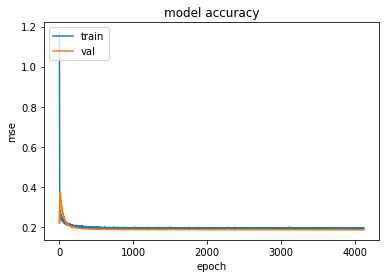

In [ ]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
x_eval = x_df.to_numpy()
y_eval = y_df.to_numpy()

x_eval = ( x_eval - np.amin(x_eval,axis=0) ) / ( np.amax(x_eval,axis=0) - np.amin(x_eval,axis=0) + 10e-10)
y_eval = ( y_eval - np.amin(y_eval,axis=0) ) / ( np.amax(y_eval,axis=0) - np.amin(y_eval,axis=0) + 10e-10)

x_eval, y_eval = create_sequences(x_eval,y_eval)


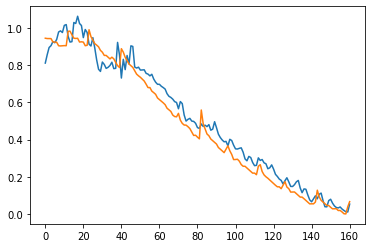

In [ ]:
plt.plot(TheNeuron.predict(x_eval))
plt.plot(y_eval)
plt.show()
#NotShuffled

In [ ]:
plt.plot(TheNeuron.predict(x_eval))
plt.plot(y_eval)
plt.show()
#Shuffled